# Table of Contents

- [Target and Settings](#Target-and-Settings)
- [Scatter Plot & Marginal Plots](#Scatter-and-Marginal-Plots-of-Samples)
- [Traces of pi](#Traces-of-$\pi$)
- [Histogram of Energies](#Histogram-of-energies)
- [2D Histogram of Samples](#2D-histogram-of-samples)
- [Thoughts about correction](#Thoughts-about-Correction)
- [Preconditioning via M](#Preconditioning)

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from utils import logp as logp_scale
from utils import normalize, logf_Jacobian, quick_MVN_marginals, quick_MVN_scatter
from ManifoldHMCAlgorithms.mixture_manifoldhmc import MixtureManifoldHMC
import matplotlib.pyplot as plt
from math import degrees, radians
from numpy.linalg import svd
from math import sqrt, log, exp
from Manifolds.RotatedEllipse import RotatedEllipse

## Target and Settings

In [2]:
# Parameters
mu = np.zeros(2)                                  # Center of the MVN
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])        # Covariance matrix of MVN
target = multivariate_normal(mean=mu, cov=Sigma)  # 2D distribution whose contours will be our manifolds

# Maximum level set value
z_max = target.pdf(mu)

In [3]:
N = 1000000
n = 1
m = 300
alpha = 0.2
T = 5 
epsilon = 0.1    
tol = 1.48e-08
a_guess = 1.0
s = 0.5
M = np.eye(2)
x0 = target.rvs()

In [4]:
samples = MixtureManifoldHMC(x0=x0, alpha=alpha, N=N, n=n, m=m, Sigma=Sigma, mu=mu, 
                             T=T, epsilon=epsilon, M=M, s=s, tol=tol, a_guess=a_guess)

## Scatter and Marginal Plots of Samples

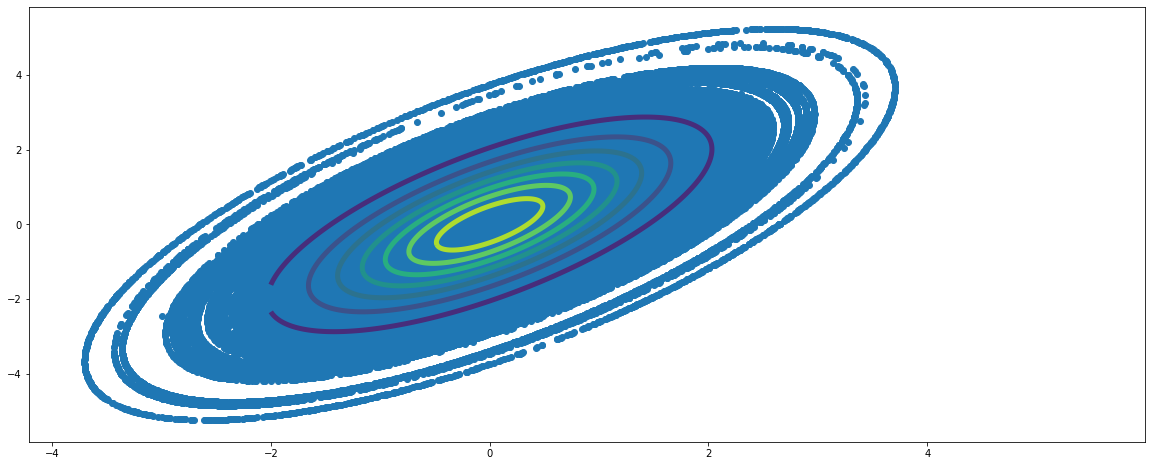

In [5]:
quick_MVN_scatter(samples, target)

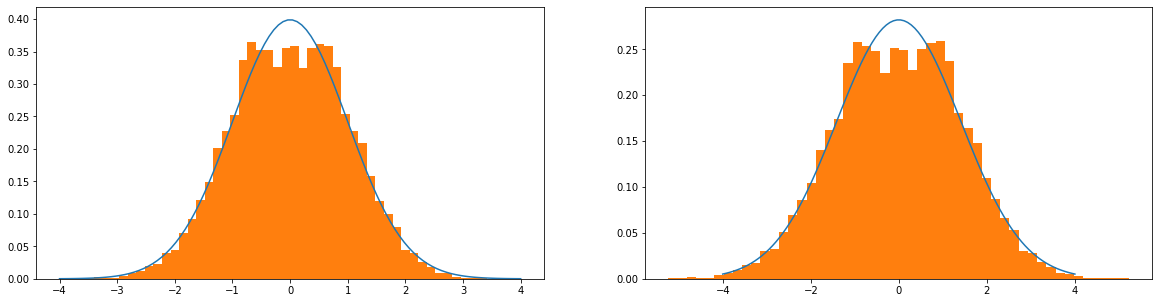

In [6]:
quick_MVN_marginals(samples, target)

## Traces of $\pi$

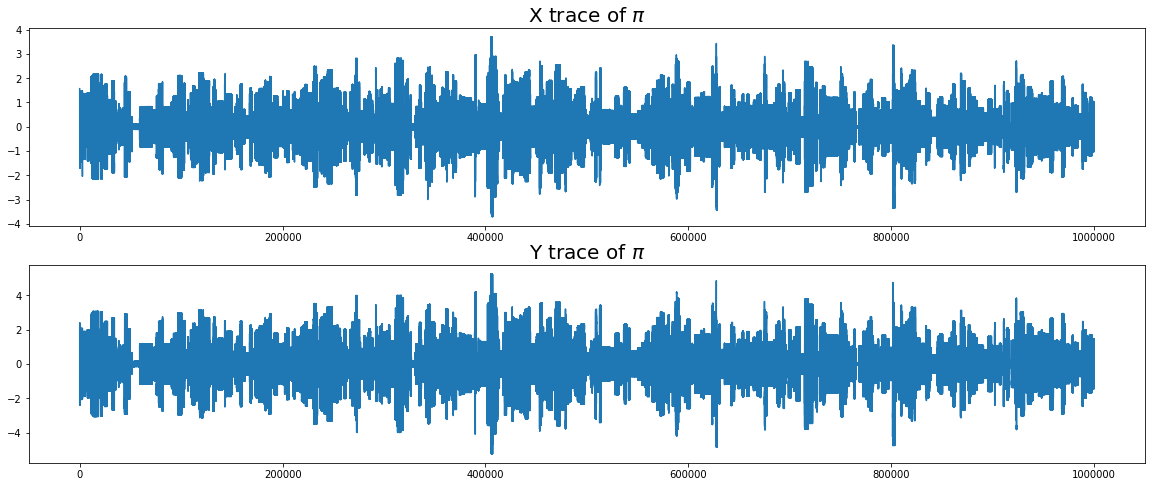

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 8))
ax[0].plot(samples[:, 0])
ax[0].set_title(r"X trace of $\pi$", fontsize=20)
ax[1].plot(samples[:, 1])
ax[1].set_title(r"Y trace of $\pi$", fontsize=20)
plt.show()

In [8]:
norm_const =np.sqrt(np.linalg.det(Sigma) * ((2*np.pi)**2))
norm_const

6.345395032201238

In [9]:
zs = np.round(target.pdf(samples), decimals=8)
zs_unique = np.unique(zs)
samples_by_contour = [samples[zs == z] for z in zs_unique]

In [10]:
logf = lambda xy: logf_Jacobian(xy, Sigma)

In [12]:
weights = [z*np.sum(np.exp(np.apply_along_axis(logf, 1, samples[zs == z]))) for z in zs_unique]

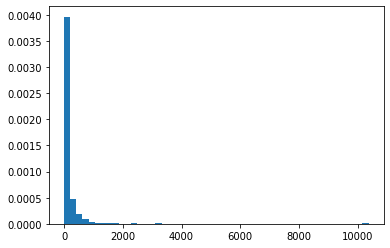

In [13]:
_ = plt.hist(weights, bins=50, density=True)

## Histogram of energies

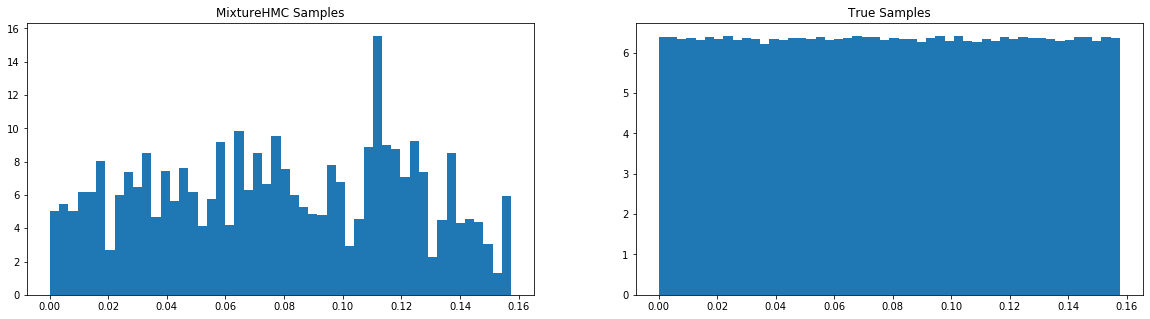

In [14]:
true_samples = target.rvs(N)
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
_ = ax[0].hist(target.pdf(samples), bins=50, density=True)
ax[0].set_title("MixtureHMC Samples")
_ = ax[1].hist(target.pdf(true_samples), bins=50, density=True)
ax[1].set_title("True Samples")
plt.show()

## 2D histogram of samples

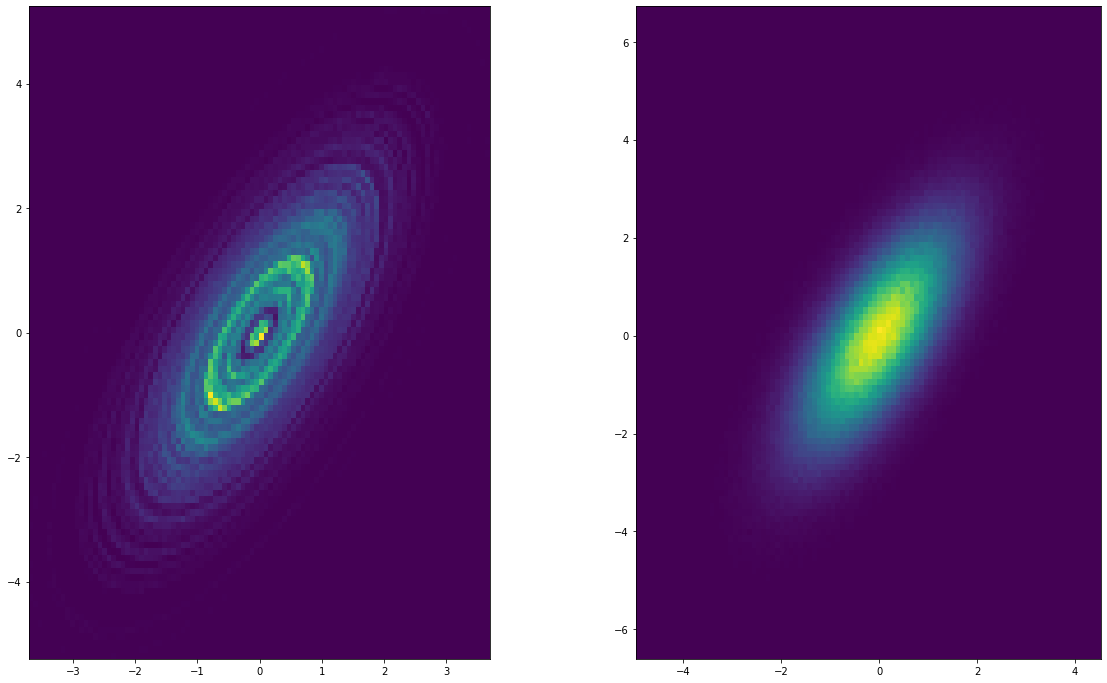

In [15]:
fig, ax = plt.subplots(figsize=(20, 12), ncols=2)
# M-HMC SAMPLES
_ = ax[0].hist2d(samples[:,0], samples[:,1], bins=[100,100], density=True) # weights
ax[0].set_aspect("equal")
# TRUE SAMPLES
_ = ax[1].hist2d(true_samples[:,0], true_samples[:,1], bins=[100,100], density=True)
ax[1].set_aspect("equal")

# Thoughts about Correction

The target density on the manifold is given below.
$$
\log f({\bf{x}}) = \frac{1}{||\nabla_{\bf{x}} \log \pi ({\bf{x}})||}
$$

Suppose ${\bf{x}}_0$ is the mode $\pi$ with density value $\pi({\bf{x}}_0) = z_0$ 

$$
{\bf{x}}_0 = \max_{\bf{x}} \log \pi({\bf{x}})
$$

Suppose also that we are targeting a manifold that is close to the singular manifold defined at a mode.

$$
\mathcal{M} = \{{\bf{x}} \in \mathbb{R}^d\, :\, \pi({\bf{x}}) = z_M\} \qquad \text{ where } z_M \approx z_0
$$

Then this means that any point ${\bf{x}}\in \mathcal{M}$ will almost be a stationary point, hence

$$
\nabla_{\bf{x}} \log \pi({\bf{x}}) \approx {\bf{0}}  \qquad \forall {\bf{x}}\in \mathcal{M}
$$

Now suppose we use HMC to move to a point ${\bf{x}}\in \mathcal{M}$ on this manifold and we propose a value ${\bf{y}}\in \mathcal{M}$ using Zappa sampling. We would the reject ${\bf{y}}$ whenever for $u \in \mathcal{U}([0,1])$

$$
\log u > \frac{1}{||\nabla_{\bf{x}} \log \pi({\bf{y}})||} - \frac{1}{||\nabla_{\bf{x}} \log \pi({\bf{x}})||}  + \log p(v') - \log p(v)
$$

Since the manifold is very close to the mode we will have

$$
\frac{1}{||\nabla_{\bf{x}} \log \pi({\bf{y}})||} \approx \frac{1}{||\nabla_{\bf{x}} \log \pi({\bf{x}})||} \approx + \infty
$$

In [16]:
# STORE THE ACCEPTANCE RATIO, THE VS AND EVERYTHING ELSE
# CHECK IF MODE IS SEVERELY UNDERESTIMATED ALSO FOR AN ISOTROPIC GAUSSIAN 
# HUG AND HOP HAS SAME ISSUE BUT FIXES IT VIA PRECONDITIONING. CAN WE DO SOMETHING SIMILAR?
# MAYBE THE PROBLEM COMES FROM THE FACT THAT WITH AN ISOTROPIC GAUSSIAN, WE HAVE ALL POINTS ON A CONTOUR
# THAT GIVE EXACTLY THE SAME GRADIENT VALUE. INSTEAD, WHEN THE GAUSSIAN IS AN ELLIPSE, SOME WILL HAVE MUCH
# LARGER GRADIENT THAN OTHERS ETC.
# OVERALL, ONCE ZAPPA REACHES THE FAR ENDS OF THE ELLIPSE, THEN IT WON'T MOVE AWAY (OR THE OTHER WAY AROUND)

# Preconditioning

In [17]:
Mhat = np.linalg.inv(np.cov(samples.T))

In [18]:
pc_samples = MixtureManifoldHMC(x0=x0, alpha=alpha, N=N, n=n, m=m, Sigma=Sigma, mu=mu, 
                             T=T, epsilon=epsilon, M=Mhat, s=s, tol=tol, a_guess=a_guess)

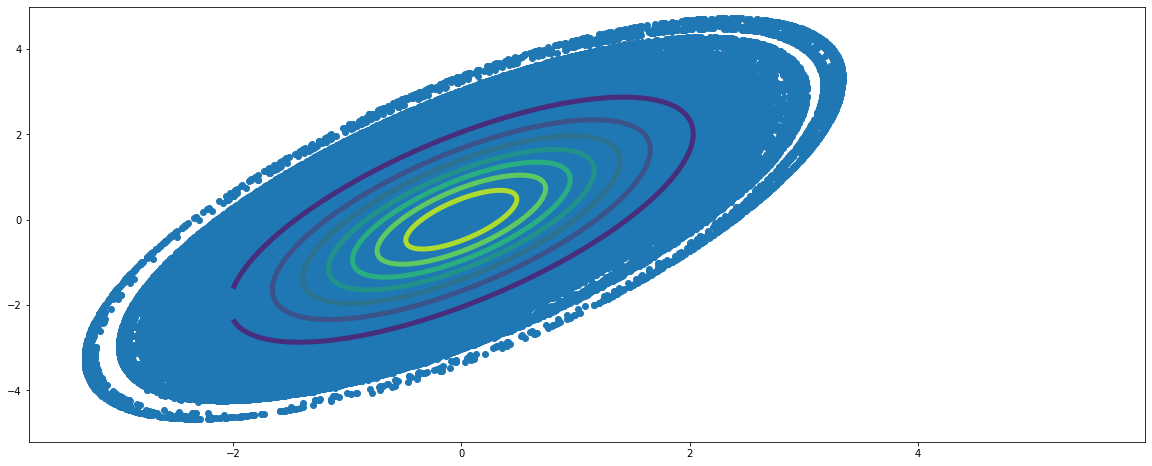

In [19]:
quick_MVN_scatter(pc_samples, target)

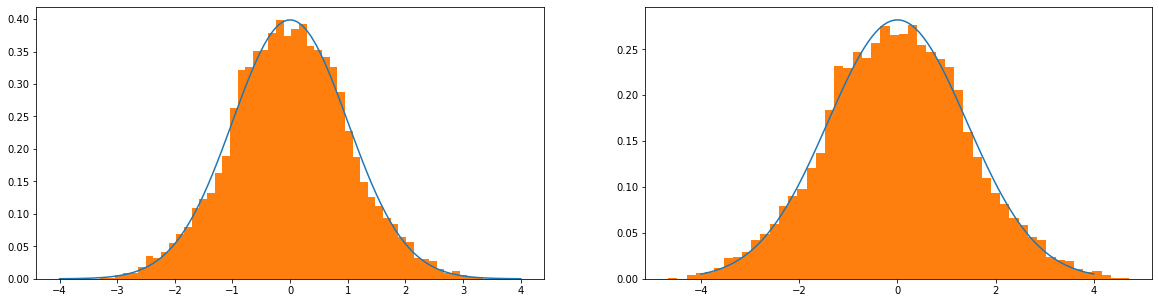

In [20]:
quick_MVN_marginals(pc_samples, target)